In [2]:
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Audio, Javascript, display, HTML
from scipy.io import wavfile
from pydub import AudioSegment
import json, random
import statistics
import math
import music21
import tensorflow_hub as hub
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [4]:
# Load audio files and extract chroma features
audio_files = glob(r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets\*\*.wav')


In [6]:
# Preprocess the audio data
def add_white_noise(data, noise_level=0.005):
    max_amplitude = np.max(np.abs(data))
    noise_amp = noise_level * max_amplitude
    white_noise = noise_amp * np.random.normal(size=len(data))
    noisy_data = data + white_noise
    return noisy_data

def time_stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def time_shift(data, max_shift_ms=50):
    shift_range = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(data, shift_range)

def random_pitch_shift(data, sr, pitch_range=(-2, 2)):
    pitch_shift_semitones = np.random.uniform(*pitch_range)
    pitch_factor = 2 ** (pitch_shift_semitones / 12.0)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=pitch_factor)

In [8]:
# Extract features from audio
def extract_features(file_path, num_mfcc=13, n_fft=2048, hop_length=512, mfcc_len=100):
    audio, sr = librosa.load(file_path, sr=None)    
    audio = add_white_noise(audio)
    audio = time_stretch(audio)
    audio = time_shift(audio)
    audio = random_pitch_shift(audio, sr)
    
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length)
    
    if mfccs.shape[1] < mfcc_len:
        mfccs = np.pad(mfccs, ((0, 0), (0, mfcc_len - mfccs.shape[1])), mode='constant')
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, mfcc_len - mel_spectrogram.shape[1])), mode='constant')
        chroma = np.pad(chroma, ((0, 0), (0, mfcc_len - chroma.shape[1])), mode='constant')
        contrast = np.pad(contrast, ((0, 0), (0, mfcc_len - contrast.shape[1])), mode='constant')
    else:
        mfccs = mfccs[:, :mfcc_len]
        mel_spectrogram = mel_spectrogram[:, :mfcc_len]
        chroma = chroma[:, :mfcc_len]
        contrast = contrast[:, :mfcc_len]
    
    features = np.vstack((mfccs, mel_spectrogram, chroma, contrast))
    label = os.path.basename(os.path.dirname(file_path)).split('. ')[1]
    
    return features, label

In [10]:
# Function to process the entire dataset
def process_dataset(dataset_path, mfcc_len=100):
    data = []
    labels = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                features, label = extract_features(file_path, mfcc_len=mfcc_len)
                data.append(features)
                labels.append(label)
    return data, labels

In [12]:
# Process the entire dataset
dataset_path = r'C:\Users\CJHx6\OneDrive\AI_Class\GIT\Group_3_Project\Resources\guitar-notes\Notes Datasets'
data, labels = process_dataset(dataset_path)

C:\Users\CJHx6\anaconda3\Lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [13]:
# Converting data to a DataFrame
data = np.array(data)
data_flat = np.array([d.flatten() for d in data])
df = pd.DataFrame(data_flat)
df['label'] = labels
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
# Split the data into training, validation, and testing sets
X = df.iloc[: ,:-1].values
Y = df['label'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.7, random_state=42, shuffle=True)

In [15]:
# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

In [16]:
# Build and compile the CNN model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(encoder.categories_[0]), activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\CJHx6\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Train the model
history = model.fit(x_train, y_train, epochs=80, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 29s 953ms/step - accuracy: 0.0462 - loss: 4.4094 - val_accuracy: 0.1838 - val_loss: 3.4524
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 27s 946ms/step - accuracy: 0.1729 - loss: 3.2202 - val_accuracy: 0.6765 - val_loss: 2.2525
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 969ms/step - accuracy: 0.4037 - loss: 2.2533 - val_accuracy: 0.8235 - val_loss: 1.0113
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 949ms/step - accuracy: 0.5601 - loss: 1.5853 - val_accuracy: 0.8971 - val_loss: 0.6456
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 950ms/step - accuracy: 0.6985 - loss: 1.0493 - val_accuracy: 0.9118 - val_loss: 0.2922
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 962ms/step - accuracy: 0.7655 - loss: 0.8279 - val_accuracy: 0.9412 - val_loss: 0.1674
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 973ms/step - accuracy: 0.7881 - loss: 0.6911 - val_accuracy: 0.9485 - val_loss: 0.1594
Epoch 8/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 960ms/step - accuracy: 0.8503 - loss: 0.5058 - val_accu

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f'Validation Loss: {loss:.3f}')
print(f'Validation Accuracy: {accuracy:.3f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9477 - loss: 0.3138
Validation Loss: 0.331
Validation Accuracy: 0.949


In [19]:
# Save the trained model
model.save('guitar_chord_recognition_model.h5')
print("Model saved successfully.")

Model saved successfully.


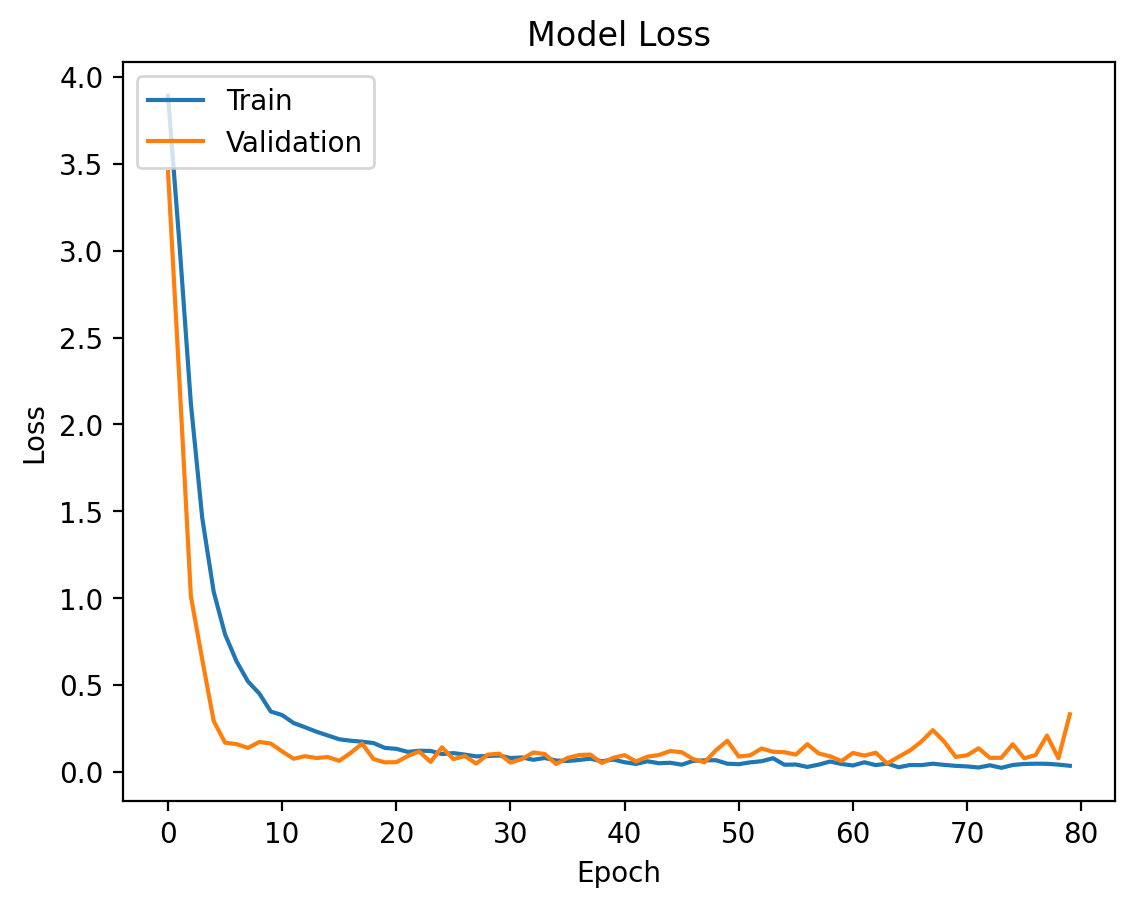

In [20]:
# Plot the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
# Load the trained model
model = load_model('guitar_chord_recognition_model.h5')

NameError: name 'load_model' is not defined

In [ ]:
# Function to predict chords in a new audio file
def predict_chords(file_path, model, encoder, scaler, mfcc_len=100):
    features, _ = extract_features(file_path, mfcc_len=mfcc_len)
    features_flat = features.flatten().reshape(1, -1)
    features_scaled = scaler.transform(features_flat)
    features_scaled = np.expand_dims(features_scaled, axis=-1)
    prediction = model.predict(features_scaled)
    predicted_label_index = np.argmax(prediction)
    predicted_label = encoder.inverse_transform(np.array([predicted_label_index]).reshape(-1, 1))
    return predicted_label[0][0]

In [ ]:
# Example usage: predict chords for a new audio file
def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
